<a href="https://colab.research.google.com/github/sbarnesthornton/sepsis-prediction/blob/main/ensemble_methods/sepsis_prediction_model_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns 
import matplotlib.pyplot as plt # matplotlib for plotting graphs

# %matplotlib inline renders plot inline on your page
%matplotlib inline

In [ ]:
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# full multivariate imputation with interpolation + all additional features
train_set = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/multivariate-with-features/temp_train_data.csv')
val_set = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/multivariate-with-features/temp_val_data.csv')
test_set = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/multivariate-with-features/temp_test_data.csv')
train_set = train_set.drop('dPatient_ID', axis=1)

In [ ]:
# class rebalancing function

def class_balancer(df):
  # Group dataframe by patient ID
  grouped_df = df.groupby('Patient_ID')
  # Check if all sepsis label values for each patient are 1
  admitted_with_sepsis = grouped_df['SepsisLabel'].all()
  # Dataframe of patients who are admitted with sepsis
  admitted_with_sepsis_df = df[df['Patient_ID'].isin(admitted_with_sepsis[admitted_with_sepsis].index)]
  # list of patients admitted with sepsis
  admitted_with_sepsis_list = admitted_with_sepsis_df.Patient_ID.unique()
  # list of patients who have sepsis
  septic_patients_list =df['Patient_ID'][df['SepsisLabel']==1].unique()
  # dataframe of septic patients
  septic_df  = df[df.Patient_ID.isin(septic_patients_list)]
  mask = ~septic_df['Patient_ID'].isin(admitted_with_sepsis_list)
  developed_sepsis_df = septic_df[mask]
  # only get septic data and the 10 hours before this from the patients who developed sepsis
  result = pd.DataFrame(columns=developed_sepsis_df.columns)
  for patient_id, group in developed_sepsis_df.groupby('Patient_ID'):
    # find the index of the first row where SepsisLabel is 1
    sepsis_index = group.index[group['SepsisLabel'] == 1]
    # select the rows for this patient, starting 10 rows before sepsis_index
    start_index = max(sepsis_index.min() - 10, 0)
    end_index = sepsis_index.max()
    selected_rows = group.loc[start_index:]
    
    result = pd.concat([result, selected_rows], axis=0)
    
  # never get sepsis patients
  num_of_zeros = result.shape[0] + admitted_with_sepsis_df.shape[0]
  nosepsis = df[~df['Patient_ID'].isin(septic_patients_list)].sample(n=num_of_zeros)
  hours_before_count = result.SepsisLabel.value_counts()[0]
  return pd.concat([admitted_with_sepsis_df, result, nosepsis]).reset_index(drop=True)


In [ ]:
def test_case(df):
  septic_patients_list =df['Patient_ID'][df['SepsisLabel']==1].unique()
  return df[~df['Patient_ID'].isin(septic_patients_list)].sample(n=1000)

In [ ]:
train_set = class_balancer(train_set)

In [ ]:
train_set.SepsisLabel.value_counts()

0    47186
1    19020
Name: SepsisLabel, dtype: int64

In [ ]:
train_y = train_set['SepsisLabel']
train_X = train_set.drop('SepsisLabel', axis = 1)

In [ ]:
# fill the final nans
train_X = train_X.fillna(-1000)

In [ ]:
train_set.shape

(66206, 316)

In [ ]:
val_set.shape

(377290, 316)

In [ ]:
# Random forsest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# optimised model
clf = RandomForestClassifier(max_depth=5,min_samples_split=6,min_samples_leaf=7,n_estimators = 1700)

# test specimin
#clf = RandomForestClassifier(max_depth=6,min_samples_split=2,min_samples_leaf=3,n_estimators = 1800)

# fit model
clf.fit(train_X, train_y.astype('int'))


RandomForestClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=6,
                       n_estimators=1700)

In [ ]:
# XGBoost 
import xgboost as xgb
# optimised hyperparameters
#|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... |
#| 9         | -0.6185   | 0.7       | 0.5       | 0.03      | 6.896     | 125.2     |
# valset 
model =  xgb.XGBClassifier(objective="binary:logistic", 
                            n_estimators = 125,
                            colsample_bytree = 0.7,
                            max_depth = 7,
                            gamma = 0.5,
                            learning_rate = 0.03,
                            random_state=42)
model.fit(train_X, train_y.astype('int'))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
test_y = test_set['SepsisLabel']
test_X = test_set.drop('SepsisLabel', axis = 1)
test_X = test_X.fillna(-1000)

# predict model
predictions = model.predict(test_X)

# f1 score
#f1score = f1_score(test_y.astype('int'), predictions,average=None)
#print(f1score)

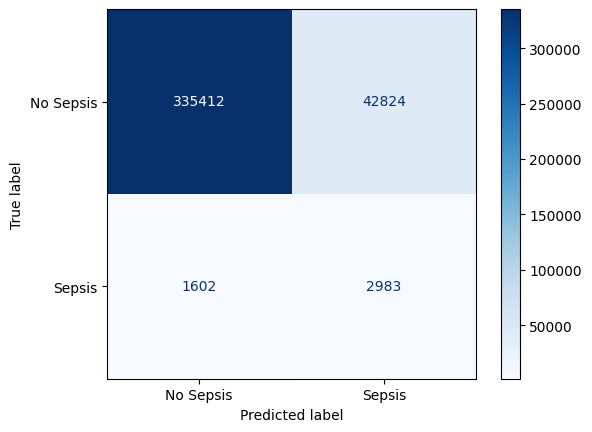

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

#CM = confusion_matrix(test_y.astype('int'), predictions, labels=clf.classes_)
ConfusionMatrixDisplay.from_predictions(test_y.astype('int'), predictions, display_labels=['No Sepsis','Sepsis'], cmap='Blues')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
#roc_auc_score(test_y.astype('int'), model.predict_proba(test_X)[:, 1])
roc_auc_score(LSTM_actual.astype('int'), LSTM_prob)

0.5710993958601802

In [ ]:
# LSTM Predictions and labels for evaluation
LSTM = pd.read_csv('/content/drive/MyDrive/sepsis-prediction/probs (1).csv')

In [ ]:
LSTM.head()

,logit,ground_truth,patient_id
0,0.205320,0.0,120563.0
1,0.213001,0.0,120563.0
2,0.224025,0.0,120563.0
3,0.244939,0.0,120563.0
4,0.270695,0.0,120563.0


In [ ]:
LSTM_prob = LSTM['logit']
LSTM_actual = LSTM['ground_truth']
LSTM_prediction = LSTM['logit'].apply(lambda x: 1 if x >= 0.5 else 0)
LSTM_patients = LSTM['patient_id']

In [ ]:
#f1_score(test_y.astype('int'),predictions, average='macro')
f1_score(LSTM_actual.astype('int'),LSTM_prediction, average='macro')

0.4635367391838924

In [ ]:
prediction_probabilities_test_set = clf.predict_proba(test_X)[:,1]

In [ ]:
patient_ID = test_X['Patient_ID']
prediction_df = pd.DataFrame({'Patient_ID': patient_ID, 'SepsisProb': prediction_probabilities_test_set})

In [ ]:
# predictions for the dashboard
prediction_df.to_csv('/content/drive/MyDrive/sepsis-prediction/test_set_prediction_probabilities_v2.csv', index=False)

In [ ]:
val_y = val_set['SepsisLabel']
val_X = val_set.drop('SepsisLabel', axis = 1)
val_X = val_set.fillna(-1000)

In [ ]:
val_X = val_X.drop('SepsisLabel',axis=1)

In [ ]:
print(val_X.shape)
print(train_X.shape)

(377290, 315)
(66206, 315)


In [ ]:
# Implementing U SCORE
def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0):
    # Check inputs for errors.
    # Does the patient eventually have sepsis?
    if np.any(labels):
        is_septic = True
        t_sepsis = np.argmax(labels) - dt_optimal 
    else:
        is_septic = False
        t_sepsis = float('inf')

    n = len(labels)

    # Define slopes and intercept points for utility functions of the form
    # u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

In [ ]:
def Uscore(y_pred, y_actual, X_actual,patientlabel):
  # Group Patients by ID
  val_y_withID = y_actual.to_frame().join(X_actual[patientlabel])
  grouped = val_y_withID.groupby(patientlabel).groups
  u_list=[]

  # Initilalise Utilities
  num_patients = val_y_withID[patientlabel].nunique()

  observed_utilities = np.zeros(num_patients)
  best_utilities = np.zeros(num_patients)
  inaction_utilities = np.zeros(num_patients)

  k = 0

  for id, idx in grouped.items():
    patient_actual = y_actual[idx[0]:idx[-1]+1]
    patient_pred = y_pred[idx[0]:idx[-1]+1]

    best_predictions = np.zeros(len(patient_actual))
    inaction_predictions = np.zeros(len(patient_actual))

    if np.any(patient_actual):
      t_sepsis = np.argmax(patient_actual) + 6
      best_predictions[max(0, t_sepsis - 12) : min(t_sepsis + 3 + 1, len(best_predictions))] = 1

    
    observed_utilities[k] = compute_prediction_utility(patient_actual,patient_pred)
    best_utilities[k] = compute_prediction_utility(patient_actual,best_predictions)
    inaction_utilities[k] = compute_prediction_utility(patient_actual, inaction_predictions)

    k += 1 

  unnormalized_observed_utility = np.sum(observed_utilities)
  unnormalized_best_utility = np.sum(best_utilities)
  unnormalized_inaction_utility = np.sum(inaction_utilities)

  return (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)

In [ ]:
LSTM_prob = LSTM['logit']
LSTM_actual = LSTM['ground_truth']
LSTM_prediction = LSTM['logit'].apply(lambda x: 1 if x >= 0.5 else 0)
LSTM_patients = LSTM['patient_id']

In [ ]:
Uscore(predictions, test_y, test_X,'Patient_ID')

0.37631200825846767

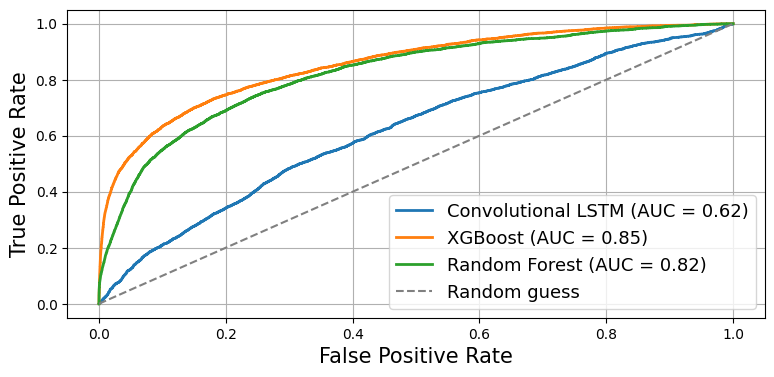

In [ ]:
# DO ROC AUC CURVE
from sklearn.metrics import roc_curve, auc

# # true labels
# y_true = test_y

# # predicted probabilities
#y_pred = model.predict_proba(test_X)[:,1]

# # calculate the FPR and TPR
fprLSTM, tprLSTM, thresholdsLSTM = roc_curve(LSTM_actual, LSTM_prob)
fprXG, tprXG, thresholdsXG = roc_curve(test_y, model.predict_proba(test_X)[:,1])
fprRF, tprRF, thresholdsRF = roc_curve(test_y, clf.predict_proba(test_X)[:,1])
# # # calculate the AUC (Area Under the Curve)
roc_auc_LSTM = auc(fprLSTM, tprLSTM)
roc_auc_XG = auc(fprXG, tprXG)
roc_auc_RF = auc(fprRF, tprRF)
# # plot the ROC curve
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(fprLSTM, tprLSTM, label='Convolutional LSTM (AUC = %0.2f)' % roc_auc_LSTM,lw=2)
ax.plot(fprXG, tprXG, label='XGBoost (AUC = %0.2f)' % roc_auc_XG,lw=2)
ax.plot(fprRF, tprRF, label='Random Forest (AUC = %0.2f)' % roc_auc_RF,lw=2)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random guess')
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)

ax.legend(loc="lower right", fontsize=13)
ax.grid(True)
plt.savefig('roc_curve_xg_lstm.png', dpi=300,bbox_inches='tight')

In [ ]:
print(roc_auc_XG)

0.8543145233922547


In [ ]:
#Sepsis probability
proba = clf.predict_proba(test_X)
prob_sepsis = proba[:,1]


In [ ]:
def accuracy_prior_to_prediction(X,y, model_type, label1, label2):  
  combined_test_set = pd.concat([X, y],axis=1)
  # group by patient ID
  groups = combined_test_set.groupby(label1)


  # iterate over groups
  for name, group in groups:
      # find the index of the first occurrence of 1
      indices = group.index[group[label2] == 1].tolist()
      if len(indices) > 0:
        idx = indices[0]
      
        # assign 1 to the previous 6 rows, if available
        if idx >= 6:
            combined_test_set.loc[idx-6:idx-1, label2] = 1
        else:
            combined_test_set.loc[:idx-1, label2] = 1

  modified = combined_test_set.copy()
  counts = modified.groupby(label1)[label2].sum()
  for patient, count in counts.items():
      if count == 16:  # do nothing
          continue
      elif count == 0:  # do nothing
          continue
      else:
          # find the index of the first occurrence of 1 in the patient's record
          idx = modified.loc[modified[label1] == patient][label2].idxmax()

          # modify the SepsisLabel column based on the number of 1s in the patient's record
          modified.loc[idx, label2] = 16-count +1 
  # initialize an empty dictionary to store the result
  print(modified.groupby(label1)[label2].sum().value_counts().to_dict())
  timeSepsis = modified.groupby(label1)[label2].cumsum()
  f1_scores = []
  for i in range(1,17):
    #idx = timeSepsis.between(i,i+1)
    idx=timeSepsis.loc[timeSepsis == i].index.tolist()
    optimal_time = combined_test_set.loc[idx]
    optimal_y = optimal_time[label2]
    optimal_X = optimal_time.drop(label2, axis = 1)
    if model_type == 'LSTM':
      f1score = accuracy_score(optimal_y, LSTM_prediction.loc[idx].to_numpy())
    else:
      pred_op_y = model_type.predict(optimal_X)
      f1score = f1_score(optimal_y, pred_op_y)
    f1_scores.append(f1score)

  return f1_scores

In [ ]:
XGB_xx = accuracy_prior_to_prediction(test_X,test_y, model,'Patient_ID','SepsisLabel')
RF_xx = accuracy_prior_to_prediction(test_X,test_y, clf, 'Patient_ID','SepsisLabel')
LSTM_xx = accuracy_prior_to_prediction(LSTM_patients,LSTM_actual, 'LSTM', 'patient_id','ground_truth')

{0: 9365, 16: 524}
{0: 9365, 16: 524}
{0.0: 8633, 16.0: 465}


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


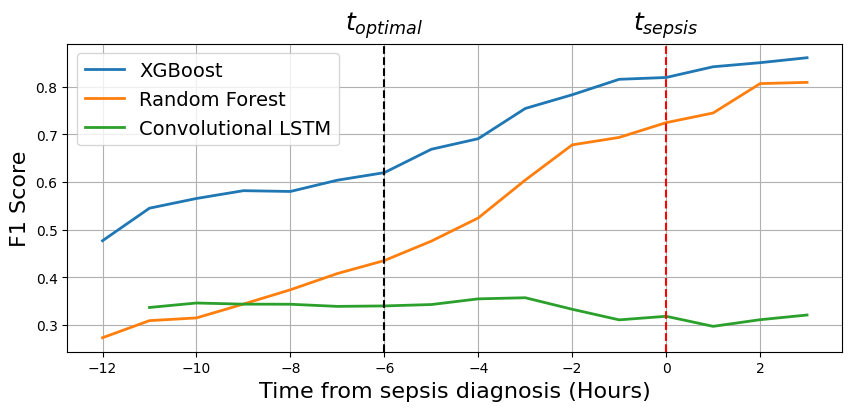

In [ ]:
time = [k for k in range(-12,4)]

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(time, XGB_xx,lw=2,label='XGBoost')
ax.plot(time, RF_xx,lw=2,label='Random Forest')
ax.plot(time, LSTM_xx,lw=2,label='Convolutional LSTM')
ax.set_xlabel('Time from sepsis diagnosis (Hours)',fontsize=16)
ax.set_ylabel('F1 Score',fontsize=16)
ax.grid(True)
ax.axvline(x=0,color='red',linestyle= '--')
ax.axvline(x=-6,color='black',linestyle= '--')
ax.text(0, 0.92, '$t_{sepsis}$', ha='center',fontsize=18)
ax.text(-6, 0.92, '$t_{optimal}$', ha='center',fontsize=18)
ax.legend(loc="upper left",fontsize=14)
plt.savefig('pred_accuracy.png', dpi=300,bbox_inches='tight')

In [ ]:
print(timeSepsis)

0         0
1         0
2         0
3         0
4         0
         ..
382816    0
382817    0
382818    0
382819    0
382820    0
Name: SepsisLabel, Length: 382821, dtype: int64
